In [1]:
#****************************************************************************
# (C) Cloudera, Inc. 2020-2025
#  All rights reserved.
#
#  Applicable Open Source License: GNU Affero General Public License v3.0
#
#  NOTE: Cloudera open source products are modular software products
#  made up of hundreds of individual components, each of which was
#  individually copyrighted.  Each Cloudera open source product is a
#  collective work under U.S. Copyright Law. Your license to use the
#  collective work is as provided in your written agreement with
#  Cloudera.  Used apart from the collective work, this file is
#  licensed for your use pursuant to the open source license
#  identified above.
#
#  This code is provided to you pursuant a written agreement with
#  (i) Cloudera, Inc. or (ii) a third-party authorized to distribute
#  this code. If you do not have a written agreement with Cloudera nor
#  with an authorized and properly licensed third party, you do not
#  have any rights to access nor to use this code.
#
#  Absent a written agreement with Cloudera, Inc. (“Cloudera”) to the
#  contrary, A) CLOUDERA PROVIDES THIS CODE TO YOU WITHOUT WARRANTIES OF ANY
#  KIND; (B) CLOUDERA DISCLAIMS ANY AND ALL EXPRESS AND IMPLIED
#  WARRANTIES WITH RESPECT TO THIS CODE, INCLUDING BUT NOT LIMITED TO
#  IMPLIED WARRANTIES OF TITLE, NON-INFRINGEMENT, MERCHANTABILITY AND
#  FITNESS FOR A PARTICULAR PURPOSE; (C) CLOUDERA IS NOT LIABLE TO YOU,
#  AND WILL NOT DEFEND, INDEMNIFY, NOR HOLD YOU HARMLESS FOR ANY CLAIMS
#  ARISING FROM OR RELATED TO THE CODE; AND (D)WITH RESPECT TO YOUR EXERCISE
#  OF ANY RIGHTS GRANTED TO YOU FOR THE CODE, CLOUDERA IS NOT LIABLE FOR ANY
#  DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, PUNITIVE OR
#  CONSEQUENTIAL DAMAGES INCLUDING, BUT NOT LIMITED TO, DAMAGES
#  RELATED TO LOST REVENUE, LOST PROFITS, LOSS OF INCOME, LOSS OF
#  BUSINESS ADVANTAGE OR UNAVAILABILITY, OR LOSS OR CORRUPTION OF
#  DATA.
#
# #  Author(s): Oliver Zarate / Paul de Fusco
#***************************************************************************/

In [2]:
import cml.data_v1 as cmldata
from pyspark.sql.functions import col, count, when
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Connect to Spark
CONNECTION_NAME = "go01-aw-dl"  # Replace with your actual connection name
conn = cmldata.get_connection(CONNECTION_NAME)
spark = conn.get_spark_session()

USERNAME = os.environ["PROJECT_OWNER"]
DBNAME = "BNK_MLOPS_HOL_"+USERNAME

# Define database and load raw data
df = spark.table('{0}.CC_TRX_{1}'.format(DBNAME, USERNAME))
#df = spark.table(f"{DBNAME}.{TABLE_NAME}")

Setting spark.hadoop.yarn.resourcemanager.principal to pauldefusco


Spark Application Id:spark-03c6e048423e45e3b215a75cb7583b58


Hive Session ID = d8dc25ec-cdc9-4b09-88dc-7050b5bd14fa


In [3]:
df.show()

+----+-------------+-------------------+--------------------+----------------+------------------------+-----------------------+---------------------------+----------------+--------------------+----------------------+----------------+---------+--------+------------------+---------+
| age|          job|credit_card_balance|bank_account_balance|mortgage_balance|sec_bank_account_balance|savings_account_balance|sec_savings_account_balance|total_est_nworth|primary_loan_balance|secondary_loan_balance|uni_loan_balance|longitude|latitude|transaction_amount|fraud_trx|
+----+-------------+-------------------+--------------------+----------------+------------------------+-----------------------+---------------------------+----------------+--------------------+----------------------+----------------+---------+--------+------------------+---------+
|75.0|       uknown|            21305.0|            16840.01|        28308.01|                51828.01|               355457.0|                   308440.0

In [4]:
# Define column types
numerical_cols = ["age", "credit_card_balance", "bank_account_balance", "mortgage_balance", "sec_bank_account_balance", "savings_account_balance", "sec_savings_account_balance"]
categorical_cols = ["job"]

# Cast numerical columns to double
for col_name in numerical_cols:
    df = df.withColumn(col_name, col(col_name).cast("double"))

# 1. Basic Descriptive Stats
print(f"Dataset Size: {df.count()} rows and {len(df.columns)} columns")
df.printSchema()
df.show(5)

Dataset Size: 40000 rows and 16 columns
root
 |-- age: double (nullable = true)
 |-- job: string (nullable = true)
 |-- credit_card_balance: double (nullable = true)
 |-- bank_account_balance: double (nullable = true)
 |-- mortgage_balance: double (nullable = true)
 |-- sec_bank_account_balance: double (nullable = true)
 |-- savings_account_balance: double (nullable = true)
 |-- sec_savings_account_balance: double (nullable = true)
 |-- total_est_nworth: float (nullable = true)
 |-- primary_loan_balance: float (nullable = true)
 |-- secondary_loan_balance: float (nullable = true)
 |-- uni_loan_balance: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- latitude: float (nullable = true)
 |-- transaction_amount: float (nullable = true)
 |-- fraud_trx: integer (nullable = true)

+----+----------+-------------------+--------------------+----------------+------------------------+-----------------------+---------------------------+----------------+--------------------+-----

In [5]:
# Summary statistics for numerical columns
summary_df = df.select(numerical_cols).describe()
summary_df.show()

+-------+-----------------+-------------------+--------------------+--------------------+------------------------+-----------------------+---------------------------+
|summary|              age|credit_card_balance|bank_account_balance|    mortgage_balance|sec_bank_account_balance|savings_account_balance|sec_savings_account_balance|
+-------+-----------------+-------------------+--------------------+--------------------+------------------------+-----------------------+---------------------------+
|  count|            40000|              40000|               40000|               40000|                   40000|                  40000|                      40000|
|   mean|         55.69525|         15677.2875|   50043.36500671995|  491865.61344267405|       49957.98085661037|     247743.55806602308|         249473.81913358794|
| stddev|23.33555208554704|  6797.678137963389|  22364.768948719502|  227101.29533866217|      22493.482315503003|     114099.29360692314|         112370.42930348928

#### Correlation Matrix

Computing Correlation Matrix...


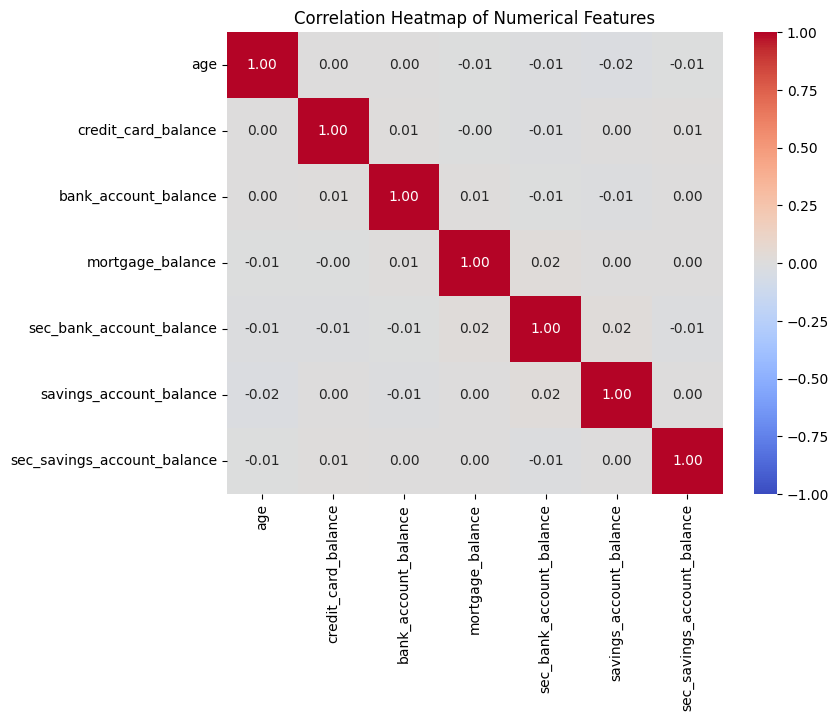

In [6]:
print("Computing Correlation Matrix...")
corr_matrix = np.zeros((len(numerical_cols), len(numerical_cols)))
for i, col1 in enumerate(numerical_cols):
    for j, col2 in enumerate(numerical_cols):
        if i <= j:
            corr_matrix[i, j] = df.stat.corr(col1, col2)
            corr_matrix[j, i] = corr_matrix[i, j]

corr_df = pd.DataFrame(corr_matrix, index=numerical_cols, columns=numerical_cols)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

In [7]:
# Correlation with target
#df = df.withColumn("y_binary", when(col("y") == "yes", 1.0).otherwise(0.0))
for col_name in numerical_cols:
    corr_value = df.stat.corr(col_name, "fraud_trx")
    print(f"Correlation between {col_name} and y_binary: {corr_value:.3f}")

Correlation between age and y_binary: -0.009


Correlation between credit_card_balance and y_binary: 0.008


Correlation between bank_account_balance and y_binary: 0.002


Correlation between mortgage_balance and y_binary: -0.007


Correlation between sec_bank_account_balance and y_binary: 0.010


Correlation between savings_account_balance and y_binary: -0.003


Correlation between sec_savings_account_balance and y_binary: 0.006


### Age Distribution

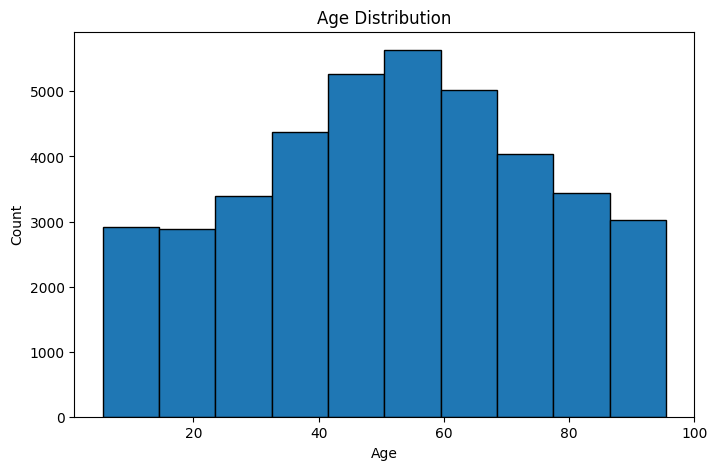

In [8]:
age_hist = df.select("age").rdd.flatMap(lambda x: x).histogram(10)
plt.figure(figsize=(8, 5))
plt.bar(age_hist[0][:-1], age_hist[1], width=(age_hist[0][1] - age_hist[0][0]), edgecolor='black')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

### Job Bar Plot

/tmp/ipykernel_130/1834671564.py:3: FutureWarning:                              

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="job", y="count", data=job_counts, palette="viridis")


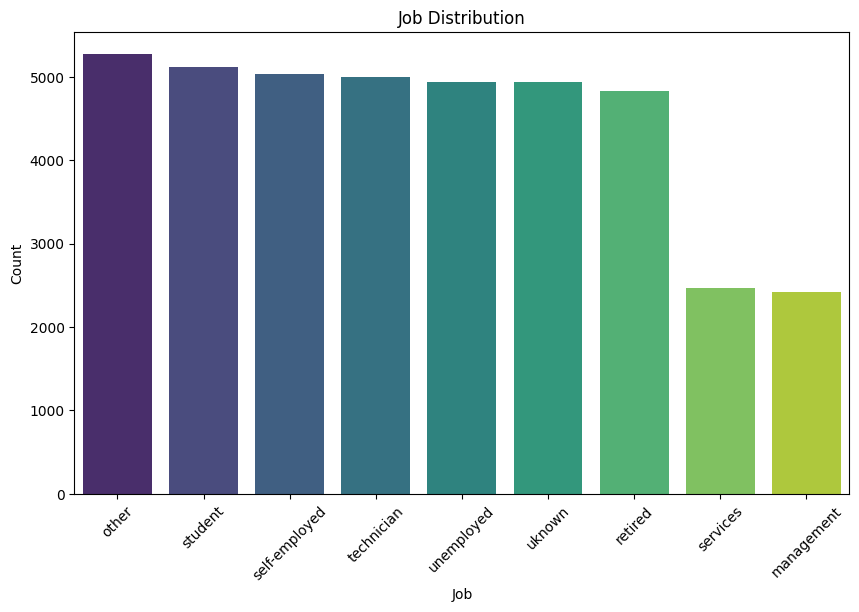

In [9]:
job_counts = df.groupBy("job").count().orderBy("count", ascending=False).toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(x="job", y="count", data=job_counts, palette="viridis")
plt.title("Job Distribution")
plt.xlabel("Job")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [10]:
print("\nTraining Decision Tree for Feature Importance...")
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx") for col in categorical_cols]
pipeline = Pipeline(stages=indexers)
df_indexed = pipeline.fit(df).transform(df)

all_features = numerical_cols + [f"{col}_idx" for col in categorical_cols]
assembler = VectorAssembler(inputCols=all_features, outputCol="features")
dt_df = assembler.transform(df_indexed)

dt = DecisionTreeClassifier(featuresCol="features", labelCol="fraud_trx", maxDepth=5)
dt_model = dt.fit(dt_df)

importances = dt_model.featureImportances
feature_importance_dict = {all_features[i]: importances[i] for i in range(len(all_features)) if importances[i] > 0}
sorted_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
total_importance = sum(importance for _, importance in sorted_importances)
print("\nFeature Importance Table:")
print(f"{'Feature':<20} {'Importance':<15} {'Percent Importance':<15}")
print("-" * 50)
for feature, importance in sorted_importances:
    percent_importance = (importance / total_importance) * 100 if total_importance > 0 else 0
    print(f"{feature:<20} {importance:<15.4f} {percent_importance:<15.2f}%")


Training Decision Tree for Feature Importance...



Feature Importance Table:
Feature              Importance      Percent Importance
--------------------------------------------------
job_idx              0.2086          20.86          %
mortgage_balance     0.1724          17.24          %
bank_account_balance 0.1435          14.35          %
credit_card_balance  0.1201          12.01          %
sec_bank_account_balance 0.1191          11.91          %
savings_account_balance 0.1106          11.06          %
sec_savings_account_balance 0.0664          6.64           %
age                  0.0594          5.94           %


### Select top features and save

In [ ]:
top_features = [f[0] for f in sorted_importances[:10]]
df_selected = df_indexed.select(top_features + ["fraud_trx"])
df_selected.show(5)
df_selected.writeTo(f"{DBNAME}.SELECTED_FEATURES_{USERNAME}")\
    .using("iceberg").tableProperty("write.format.default", "parquet")\
    .createOrReplace()
print("Selected features saved as {}.SELECTED_FEATURES_{}".format(DBNAME, USERNAME))

# Verify the save
print("Tables in {}:".format(USERNAME))
spark.sql(f"SHOW TABLES IN {DBNAME}").show(truncate=False)

+-------+----------------+--------------------+-------------------+------------------------+-----------------------+---------------------------+----+---------+
|job_idx|mortgage_balance|bank_account_balance|credit_card_balance|sec_bank_account_balance|savings_account_balance|sec_savings_account_balance| age|fraud_trx|
+-------+----------------+--------------------+-------------------+------------------------+-----------------------+---------------------------+----+---------+
|    5.0| 28308.009765625|     16840.009765625|            21305.0|          51828.01171875|               355457.0|                   308440.0|75.0|        0|
|    4.0|        596398.0|     15265.009765625|             4287.0|         21743.009765625|               402794.0|                   321811.0|87.0|        1|
|    8.0|        858722.0|  137.00999450683594|            15322.0|         22198.009765625|               298947.0|                   363054.0|90.0|        0|
|    3.0|        919655.0|      6776.009